In [1]:
#相关环境配置
import paddle
from paddlenlp.datasets import MapDataset
from paddlenlp.transformers import ErnieTokenizer, ErnieForTokenClassification
from utils import convert_example, evaluate, predict, load_dict
import numpy as np
from paddle.io import DataLoader
import paddlenlp as ppnlp
from paddlenlp.datasets import load_dataset
from paddlenlp.data import Stack, Tuple, Pad, Dict
from paddlenlp.metrics import ChunkEvaluator
from functools import partial

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/scipy/sparse/sputils.py:16: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  supported_dtypes = [np.typeDict[x] for x in supported_dtypes]
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/scipy/special/orthogonal.py:81: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from numpy import (exp, inf, pi, sqrt, floor, sin, cos, around, int,
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/scipy/linalg/__init__.py:217: Depre

In [2]:
#.数据格式调整
import os
def format_data(source_filename, target_filename):
    datalist=[]
    with open(source_filename, 'r', encoding='utf-8') as f:
        lines=f.readlines()
    words=''
    labels=''
    flag=0
    for line in lines:  
        if line == '\n':
            item=words+'\t'+labels+'\n'
            # print(item)
            datalist.append(item)
            words=''
            labels=''
            flag=0
            continue
        word, label = line.strip('\n').split(' ')
        if flag==1:
            words=words+'\002'+word
            labels=labels+'\002'+label
        else:
            words=words+word
            labels=labels+label
            flag=1
    with open(target_filename, 'w', encoding='utf-8') as f:
        lines=f.writelines(datalist)
    print(f'{source_filename}文件格式转换完毕，保存为{target_filename}')

In [3]:
#加载自定义数据集，使用MapDataset()自定义数据集
def load_dataset(datafiles):
    def read(data_path):
        with open(data_path, 'r', encoding='utf-8') as fp:
            next(fp)  # Skip header
            for line in fp.readlines():
                words, labels = line.strip('\n').split('\t')
                words = words.split('\002')
                labels = labels.split('\002')
                yield words, labels

    if isinstance(datafiles, str):
        return MapDataset(list(read(datafiles)))
    elif isinstance(datafiles, list) or isinstance(datafiles, tuple):
        return [MapDataset(list(read(datafile))) for datafile in datafiles]        

In [4]:
# label标签表构建
#之后，还需要对输入句子进行数据处理，如切词，映射词表id等。
def gernate_dic(source_filename1, source_filename2, target_filename):
    data_list=[]

    with open(source_filename1, 'r', encoding='utf-8') as f:
        lines=f.readlines()

    for line in lines:
        if line != '\n':
            dic=line.strip('\n').split(' ')[-1]
            if dic+'\n' not in data_list:
                data_list.append(dic+'\n')
    
    with open(source_filename2, 'r', encoding='utf-8') as f:
        lines=f.readlines()

    for line in lines:
        if line != '\n':
            dic=line.strip('\n').split(' ')[-1]
            if dic+'\n' not in data_list:
                data_list.append(dic+'\n')

    with open(target_filename, 'w', encoding='utf-8') as f:
        lines=f.writelines(data_list)    

In [5]:
format_data('dataset/dev.conll', 'dataset/dev.txt')
format_data(r'dataset/train.conll', r'dataset/train.txt')
train_ds, dev_ds = load_dataset(datafiles=(
        './dataset/train.txt', './dataset/dev.txt'))
# 从dev文件生成dic
gernate_dic('dataset/train.conll', 'dataset/dev.conll', 'dataset/mytag.dic')
#tokenizer作用为将原始输入文本转化成模型model可以接受的输入数据形式。
label_vocab = load_dict('./dataset/mytag.dic')
tokenizer = ErnieTokenizer.from_pretrained('ernie-1.0')

trans_func = partial(convert_example, tokenizer=tokenizer, label_vocab=label_vocab)

train_ds.map(trans_func)
dev_ds.map(trans_func)

dataset/dev.conll文件格式转换完毕，保存为dataset/dev.txt
dataset/train.conll文件格式转换完毕，保存为dataset/train.txt


[2022-12-23 20:13:14,610] [    INFO] - Downloading vocab.txt from https://paddlenlp.bj.bcebos.com/models/transformers/ernie/vocab.txt
100%|██████████| 90/90 [00:00<00:00, 33459.26it/s]


In [6]:
#数据读入
ignore_label = -1
batchify_fn = lambda samples, fn=Tuple(
    Pad(axis=0, pad_val=tokenizer.pad_token_id),  # input_ids
    Pad(axis=0, pad_val=tokenizer.pad_token_type_id),  # token_type_ids
    Stack(),  # seq_len
    Pad(axis=0, pad_val=ignore_label)  # labels
): fn(samples)
#使用paddle.io.DataLoader接口多线程异步加载数据
train_loader = paddle.io.DataLoader(
    dataset=train_ds,
    batch_size=300,
    return_list=True,
    collate_fn=batchify_fn)
dev_loader = paddle.io.DataLoader(
    dataset=dev_ds,
    batch_size=300,
    return_list=True,
    collate_fn=batchify_fn)

In [7]:
#加载预训练模型
model = ErnieForTokenClassification.from_pretrained("ernie-1.0", num_classes=len(label_vocab))
#设置Fine-Tune优化策略，模型配置
metric = ChunkEvaluator(label_list=label_vocab.keys(), suffix=True)
loss_fn = paddle.nn.loss.CrossEntropyLoss(ignore_index=ignore_label)
optimizer = paddle.optimizer.AdamW(learning_rate=2e-5, parameters=model.parameters())

[2022-12-23 20:13:20,279] [    INFO] - Downloading https://paddlenlp.bj.bcebos.com/models/transformers/ernie/ernie_v1_chn_base.pdparams and saved to /home/aistudio/.paddlenlp/models/ernie-1.0
[2022-12-23 20:13:20,282] [    INFO] - Downloading ernie_v1_chn_base.pdparams from https://paddlenlp.bj.bcebos.com/models/transformers/ernie/ernie_v1_chn_base.pdparams
100%|██████████| 392507/392507 [00:06<00:00, 62312.80it/s]
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dygraph/layers.py:1301: UserWarning: Skip loading for classifier.weight. classifier.weight is not found in the provided dict.
  warnings.warn(("Skip loading for {}. ".format(key) + str(err)))
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dygraph/layers.py:1301: UserWarning: Skip loading for classifier.bias. classifier.bias is not found in the provided dict.
  warnings.warn(("Skip loading for {}. ".format(key) + str(err)))


In [ ]:
#开始训练
step = 0
steps=[]
losses=[]
epochs=[]
for epoch in range(60):#这里测试的时候可以是1，实际训练时是60
    for idx, (input_ids, token_type_ids, length, labels) in enumerate(train_loader):
        logits = model(input_ids, token_type_ids)
        loss = paddle.mean(loss_fn(logits, labels))
        loss.backward()
        optimizer.step()
        optimizer.clear_grad()
        step += 1
        steps.append(step)
        losses.append(loss)
        print("epoch:%d - step:%d - loss: %f" % (epoch, step, loss))
    evaluate(model, metric, dev_loader)
    epochs.append(epoch)
    paddle.save(model.state_dict(),
                './checkpoint/model_%d.pdparams' % step)
                


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dygraph/math_op_patch.py:239: UserWarning: The dtype of left and right variables are not the same, left dtype is paddle.float32, but right dtype is paddle.bool, the right dtype will convert to paddle.float32
  format(lhs_dtype, rhs_dtype, lhs_dtype))


epoch:0 - step:1 - loss: 4.143913
epoch:0 - step:2 - loss: 4.013627


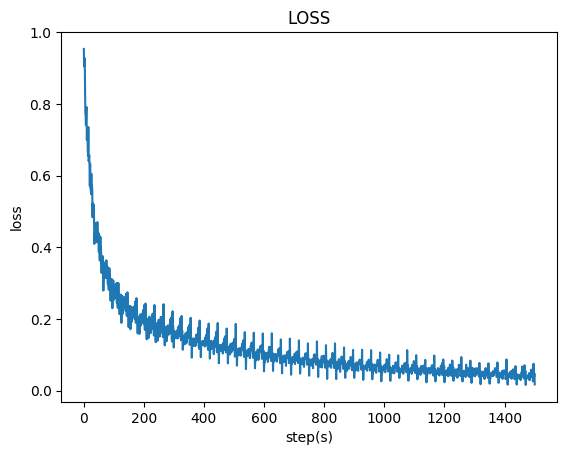

In [ ]:
import matplotlib.pyplot as plt
plt.xlabel("step(s)")     # X轴标签
plt.ylabel("loss")        # Y轴坐标标签
plt.title("LOSS")      #  曲线图的标题
plt.plot(steps,losses)            # 绘制曲线图
plt.show()

In [1]:
!mkdir ernie_result
model.save_pretrained('./ernie_result')
tokenizer.save_pretrained('./ernie_result')

In [ ]:
#定义test数据集
def load_dataset(datafiles):
    def read(data_path):
        with open(data_path, 'r', encoding='utf-8') as fp:
            # next(fp)  # 没有header，不用Skip header
            for line in fp.readlines():
                ids, words = line.strip('\n').split('\001')
                words=[ch for ch in words]
                # 要预测的数据集没有label，伪造个O，不知道可以不 ，应该后面预测不会用label
                labels=['O' for x in range(0,len(words))]

                yield words, labels
                # yield words

    if isinstance(datafiles, str):
        return MapDataset(list(read(datafiles)))
    elif isinstance(datafiles, list) or isinstance(datafiles, tuple):
        return [MapDataset(list(read(datafile))) for datafile in datafiles]      

In [ ]:
#打开测试集数据
test_ds = load_dataset(datafiles=('./dataset/final_test.txt'))

In [ ]:
加载训练好的模型
label_vocab = load_dict('./dataset/mytag.dic')
tokenizer = ErnieTokenizer.from_pretrained('ernie-1.0')

trans_func = partial(convert_example, tokenizer=tokenizer, label_vocab=label_vocab)
test_ds.map(trans_func)
print (test_ds[0])

[2022-12-23 15:40:43,377] [    INFO] - Found /home/aistudio/.paddlenlp/models/ernie-1.0/vocab.txt


([1, 705, 507, 121, 96, 129, 252, 155, 540, 540, 540, 17963, 540, 500, 2], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 15, [24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24])

In [ ]:
ignore_label = 1
batchify_fn = lambda samples, fn=Tuple(
    Pad(axis=0, pad_val=tokenizer.pad_token_id),  # input_ids
    Pad(axis=0, pad_val=tokenizer.pad_token_type_id),  # token_type_ids
    Stack(),  # seq_len
    Pad(axis=0, pad_val=ignore_label)  # labels
): fn(samples)

In [ ]:
test_loader = paddle.io.DataLoader(
    dataset=test_ds,
    batch_size=30,
    return_list=True,
    collate_fn=batchify_fn)

In [ ]:
def my_predict(model, data_loader, ds, label_vocab):
    pred_list = []
    len_list = []
    for input_ids, seg_ids, lens, labels in data_loader:
        logits = model(input_ids, seg_ids)
        # print(len(logits[0]))
        pred = paddle.argmax(logits, axis=-1)
        pred_list.append(pred.numpy())
        len_list.append(lens.numpy())
    preds ,tags= parse_decodes(ds, pred_list, len_list, label_vocab)
    return preds, tags

In [ ]:
model = ErnieForTokenClassification.from_pretrained("ernie-1.0", num_classes=len(label_vocab))
model_dict = paddle.load('ernie_result/model_state.pdparams')
model.set_dict(model_dict)
from utils import *
preds, tags = my_predict(model, test_loader, test_ds, label_vocab)

In [ ]:
#预测并保存
file_path = "ernie_results1.txt"
with open(file_path, "w", encoding="utf8") as fout:
    fout.write("\n".join(preds))
# Print some examples
#转换保存结果
def main():
    data_list = []
    with open('ernie_results.txt', encoding='utf-8') as f:
        data_list = f.readlines()
    return data_list
if __name__ == "__main__":
    print('1^ A浙江杭州阿里^AB-prov E-prov B-city E-city B-poi E-poi')
    sentence_list = main()
    print(len(sentence_list))

    final_test = []
    with open('dataset/final_test.txt', encoding='utf-8') as f:
        final_test = f.readlines()
    test_data = []
    print(f'{len(final_test)}\t\t{len(sentence_list)}')
    for i in range(len(final_test)):
        # test_data.append(final_test[i].strip('\n') + '\001' + sentence_list[i] + '\n')
        test_data.append(final_test[i].strip('\n').strip(' ') + '\001' + sentence_list[i].strip(' '))
    with open('predict1.txt', 'w', encoding='utf-8') as f:
        f.writelines(test_data)
    print(50 * '*')
    print('write result ok!')
    print(50 * '*')

The results have been saved in the file: ernie_results1.txt, some examples are shown below: 


In [ ]:
import linecache
#提交格式检查
def check(submit_path, test_path, max_num=50000):
    N = 0
    with open(submit_path, 'r', encoding='utf-8') as fin:
        for line in fin:
            line = line.strip()
            if line == '':
                continue
            N += 1
            parts = line.split('\001')  # id, sent, tags
            if len(parts) != 3:
                raise AssertionError(f"分隔符不正确，写入文件时请用'\\001'来分隔ID，句子和预测标签！Error Line:{line.strip()}")
            elif len(parts[1]) != len(parts[2].split(' ')):
                print(line)
                raise AssertionError(f"请保证句子长度和标签长度一致，且标签之间用空格分隔！ID:{parts[0]} Sent:{parts[1]}")
            elif parts[0] != str(N):
                raise AssertionError(f"请保证测试数据的ID合法！ID:{parts[0]} Sent:{parts[1]}")
            else:
                for tag in parts[2].split(' '):
                    if (tag == 'O' or tag.startswith('S-')
                        or tag.startswith('B-')
                        or tag.startswith('I-')
                        or tag.startswith('E-')) is False:
                        raise AssertionError(f"预测结果存在不合法的标签！ID:{parts[0]} Tag:{parts[2]}")

                test_line = linecache.getline(test_path, int(parts[0]))
                test_sent = test_line.strip().split('\001')[1]
                if test_sent.strip() != parts[1].strip():
                    raise AssertionError(f"请不要改变测试数据原文！ID:{parts[0]} Sent:{parts[1]}")
    if N != max_num:
        raise AssertionError(f"请保证测试数据的完整性(共{max_num}条)，不可丢失或增加数据！")
    print('测试集预测结果输出成功')

    
check('predict1.txt', 'dataset/final_test.txt')


测试集预测结果输出成功
